In [ ]:
import numpy as np
import pandas as pd
from math import log
import matplotlib.pyplot as plt
import operator
from sklearn.datasets import load_iris
import csv
import random
import math

def read_iris_dataset():
    dataset = []
    with open('Iris.csv', newline='') as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        is_first = True
        for row in reader:

            instance = {}
            if not is_first:
                # skip first row
                instance["SepalLengthCm"] = float(row[1])
                instance["SepalWidthCm"] = float(row[2])
                instance["PetalLengthCm"] = float(row[3])
                instance["PetalWidthCm"] = float(row[4])
                instance["Species"] = row[5]
                dataset.append(instance)
            is_first = False

    return dataset

dataset = read_iris_dataset()
# print first 5 row
print(dataset[:5])

In [ ]:
# Calculate the entropy of the target label
def entropy(dataset):
    if len(dataset) == 0:
        return 0

    target_attribute_name = "Species"
    target_attribute_values = ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]

    data_entropy = 0
    
    for val in target_attribute_values:

        # calculate the probability p that an element in the set has the value val
        p = len([elem for elem in dataset if elem[target_attribute_name] == val]) / len(dataset)

        if p > 0:
            data_entropy += -p * math.log(p, 2)

    return data_entropy


random.shuffle(dataset)  # to have different class
entropy(dataset[:10])

In [ ]:
#Information Gain
# Calculate the average entropy of splitting over an attribute
def info_gain(attribute_name, split, dataset):
    # split set and calculate probabilities that elements are in the splits
    # Split the dataset and calculate the p that the attribute_name is in split (before and after the threshold)）
    set_smaller = [elem for elem in dataset if elem[attribute_name] < split]
    p_smaller = len(set_smaller) / len(dataset)
    set_greater_equals = [elem for elem in dataset if elem[attribute_name] >= split]
    p_greater_equals = len(set_greater_equals) / len(dataset)

    #Calculate the information gain, （represents the degree of information entropy reduction）
    #Select the feature that maximizes information gain
    info_gain_val = entropy(dataset)
    info_gain_val -= p_smaller * entropy(set_smaller)
    info_gain_val -= p_greater_equals * entropy(set_greater_equals)

    return info_gain_val

# The information gain of all attributes is calculated, 
# and the criterion of maximizing the information gain and the optimal segmentation are obtained
def max_information_gain(attribute_list, attribute_values, dataset):
    max_info_gain = 0
    for attribute in attribute_list:  # test all input attributes
        for split in attribute_values[attribute]:  
            split_info_gain = info_gain(attribute, split, dataset)  
            # calculate information gain
            if split_info_gain >= max_info_gain:
                max_info_gain = split_info_gain
                max_info_gain_attribute = attribute
                max_info_gain_split = split
    return max_info_gain, max_info_gain_attribute, max_info_gain_split



In [ ]:
MINIMUM_SAMPLE_SIZE = 4
MAX_TREE_DEPTH = 3


class tree_node:

    def __init__(self, training_set, attribute_list, attribute_values, tree_depth):
        self.is_leaf = False
        self.dataset = training_set
        self.split_attribute = None
        self.split = None
        self.attribute_list = attribute_list
        self.attribute_values = attribute_values
        self.left_child = None
        self.right_child = None
        self.prediction = None
        self.depth = tree_depth

    def build(self):

        training_set = self.dataset

        if self.depth < MAX_TREE_DEPTH and len(training_set) >= MINIMUM_SAMPLE_SIZE and len(
                set([elem["Species"] for elem in training_set])) > 1:
            # get attribute and split with highest information gain
            max_gain, attribute, split = max_information_gain(self.attribute_list, self.attribute_values, training_set)
            print("depth {}, attribute {} split value {}, max split info gain: {}".format(self.depth, attribute, split, max_gain))

            # Test whether the information gain is greater than zero
            if max_gain > 0:
                # split tree
                self.split = split
                self.split_attribute = attribute

                # Create the left and right nodes of the decision tree
                training_set_l = [elem for elem in training_set if elem[attribute] < split]
                training_set_r = [elem for elem in training_set if elem[attribute] >= split]
                self.left_child = tree_node(training_set_l, self.attribute_list, self.attribute_values, self.depth + 1)
                self.right_child = tree_node(training_set_r, self.attribute_list, self.attribute_values, self.depth + 1)
                self.left_child.build()
                self.right_child.build()
            else:
                self.is_leaf = True
        else:
            self.is_leaf = True

        if self.is_leaf:
        
            setosa_count = versicolor_count = virginica_count = 0
            for elem in training_set:
                if elem["Species"] == "Iris-setosa":
                    setosa_count += 1
                elif elem["Species"] == "Iris-versicolor":
                    versicolor_count += 1
                else:
                    virginica_count += 1
            dominant_class = "Iris-setosa"
            dom_class_count = setosa_count
            if versicolor_count >= dom_class_count:
                dom_class_count = versicolor_count
                dominant_class = "Iris-versicolor"
            if virginica_count >= dom_class_count:
                dom_class_count = virginica_count
                dominant_class = "Iris-virginica"
            self.prediction = dominant_class

    # Test the accuracy of the decision tree
    def predict(self, sample):
        if self.is_leaf:
            return self.prediction
        else:
            if sample[self.split_attribute] < self.split:
                return self.left_child.predict(sample)
            else:
                return self.right_child.predict(sample)

    def merge_leaves(self):
        if not self.is_leaf:
            self.left_child.merge_leaves()
            self.right_child.merge_leaves()
            if self.left_child.is_leaf and self.right_child.is_leaf and self.left_child.prediction == self.right_child.prediction:
                self.is_leaf = True
                self.prediction = self.left_child.prediction

    def print(self, prefix):
        if self.is_leaf:
            print("\t" * self.depth + prefix + self.prediction)
        else:
            print("\t" * self.depth + prefix + self.split_attribute + "<" + str(self.split) + "?")
            self.left_child.print("[True] ")
            self.right_child.print("[False] ")



In [ ]:

class ID3_tree:
    def __init__(self):
        self.root = None

    def build(self, training_set, attribute_list, attribute_values):
        self.root = tree_node(training_set, attribute_list, attribute_values, 0)
        self.root.build()

    def merge_leaves(self):
        self.root.merge_leaves()

    def predict(self, sample):
        return self.root.predict(sample)

    def print(self):
        print("----------------")
        print("DECISION TREE")
        self.root.print("")
        print("----------------")



In [ ]:
dataset = read_iris_dataset()
if not dataset:
    # dataset is empty
    print('dataset is empty!')
    exit(1)

# Twenty-five percent of the sample was randomly selected
seed = 42
np.random.seed(seed)
random.seed(seed)

num = len(dataset)
test_indices = random.sample(range(num), int(0.25 * num))
print(test_indices)
test_set = np.array(dataset)[test_indices]
training_set = [dataset[i] for i in range(num) if not i in test_indices ]
# test_set = random.sample(dataset, int(0.25 * len(dataset)))
# test_set_dupl = test_set.copy()  # only needed to generate training set
# training_set = [i for i in dataset if not i in test_set_dupl or test_set_dupl.remove(i)]
print('dataset size:', len(dataset))
print('training set size:', len(training_set))
print('test set size:', len(test_set))

attr_list = ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]

attr_domains = {}
for attr in attr_list:
    attr_domain = set()
    for s in dataset:
        attr_domain.add(s[attr])
    attr_domains[attr] = list(attr_domain)
print("attr_domains (all possible value): {}".format(attr_domains))
# build decision tree
dt = ID3_tree()
dt.build(dataset, attr_list, attr_domains)
dt.merge_leaves()  # merge leaves with the same prediction

# calculate accuracy with test set
accuracy = 0
for sample in test_set:
    if sample["Species"] == dt.predict(sample):
        accuracy += (1/len(test_set))

dt.print()

print("accuracy on test set: " + "{:.2f}".format(accuracy * 100) + "%")

[28, 6, 70, 62, 57, 35, 26, 139, 22, 108, 8, 7, 23, 55, 59, 129, 148, 50, 107, 56, 114, 71, 1, 97, 103, 20, 89, 54, 43, 144, 19, 27, 126, 121, 13, 11, 48]
dataset size: 150
training set size: 113
test set size: 37
attr_domains (all possible value): {'SepalLengthCm': [4.7, 5.5, 5.0, 4.9, 5.1, 4.6, 5.4, 4.4, 4.8, 4.3, 5.8, 7.0, 7.1, 4.5, 5.9, 5.6, 6.9, 6.5, 6.4, 6.6, 6.0, 6.1, 7.6, 7.4, 7.9, 5.7, 5.3, 5.2, 6.3, 6.7, 6.2, 6.8, 7.3, 7.2, 7.7], 'SepalWidthCm': [2.9, 3.0, 3.5, 3.2, 3.6, 3.1, 3.9, 3.4, 3.7, 4.0, 4.4, 4.1, 2.0, 2.5, 2.6, 2.3, 2.8, 2.7, 2.2, 3.8, 3.3, 4.2, 2.4], 'PetalLengthCm': [1.7, 1.4, 1.6, 1.3, 1.5, 1.1, 1.2, 1.0, 1.9, 4.7, 4.5, 4.9, 4.0, 5.0, 6.0, 3.5, 3.0, 4.6, 4.4, 4.1, 5.1, 5.9, 5.6, 5.5, 5.4, 6.6, 6.1, 6.9, 6.4, 3.6, 3.3, 3.8, 3.7, 4.2, 4.8, 4.3, 5.8, 5.3, 5.7, 5.2, 6.3, 6.7, 3.9], 'PetalWidthCm': [0.2, 0.4, 0.3, 0.5, 0.6, 1.4, 1.5, 1.3, 1.6, 1.0, 1.1, 2.5, 2.0, 2.1, 1.2, 1.7, 0.1, 2.2, 2.3, 1.8, 1.9, 2.4]}
depth 0, attribute PetalWidthCm split value 1.0, max split in

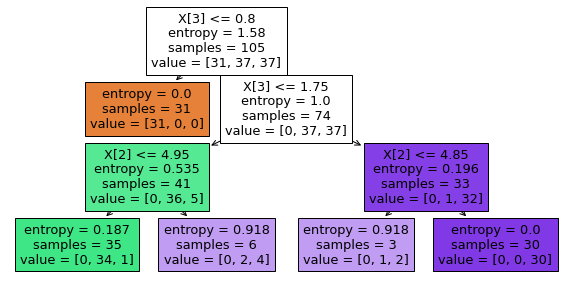

feature weight :  [0.         0.         0.08988642 0.91011358]
decision tree score :  1.0


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
iris = load_iris()

features = iris['data']

target = iris['target']
feature_names = iris.feature_names
feature_names = ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]

class_names = iris.target_names
# ['setosa', 'versicolor', 'virginica']
class_names = ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(max_depth=3, criterion='entropy')


show_parms_max_depth_3 = clf.fit(X_train, y_train)
plt.figure(figsize = (10,5))
plot_tree(show_parms_max_depth_3, filled=True)
plt.show()

print("feature weight : ", clf.feature_importances_)

print("decision tree score : ", clf.score(X=X_test, y=y_test))